In [2]:
from abc import ABC, abstractmethod
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

sns.set_style("white")

In [3]:
class Data(ABC):
    @abstractmethod
    def sample(self):
        pass

    @abstractmethod
    def k_z_next(self, z_next):
        pass

    @abstractmethod
    def update_model(self, z_next):
        pass

    @abstractmethod
    def reset(self):
        pass


class RandomData(Data):
    def __init__(self, z_dim):
        self.z_dim = z_dim

    def sample(self):
        return "".join([str(int(random() > 0.5)) for _ in range(self.z_dim)])

    def k_z_next(self, z_next):
        return self.z_dim

    def update_model(self, z_next):
        return

    def reset(self):
        return


class CompositionalData(Data):
    def __init__(self, z_dim, sentence_length, vocab_size, noise_dims=0):
        self.z_dim = z_dim
        self.noise_dims = noise_dims
        self.sentence_length = sentence_length
        self.vocab_size = vocab_size
        self.word_dim = (z_dim - noise_dims) // sentence_length
        assert vocab_size <= 2**self.word_dim

        self.true_model = [
            [format(i, f"0{self.word_dim}b") for i in range(vocab_size)]
            for _ in range(sentence_length)
        ]
        self.model = None
        self.reset()

    def chunk_z(self, z):
        return [
            z[i : i + self.word_dim]
            for i in range(0, self.z_dim - self.noise_dims, self.word_dim)
        ]

    def sample(self):
        sentence = [
            int(random() * self.vocab_size) for _ in range(self.sentence_length)
        ]
        z = "".join([self.true_model[i][word] for i, word in enumerate(sentence)])
        z += "".join([str(int(random() > 0.5)) for _ in range(self.noise_dims)])
        return z

    def k_z_next(self, z_next):
        z_next = z_next[: -self.noise_dims] if self.noise_dims > 0 else z_next
        z_next = self.chunk_z(z_next)
        k = 0.0
        for i, z_chunk in enumerate(z_next):
            if z_chunk not in self.model[i]:
                k += self.word_dim
            else:
                k += np.log2(len(self.model[i]))
        k += self.noise_dims
        return k

    def update_model(self, z_next):
        z_next = z_next[: -self.noise_dims] if self.noise_dims > 0 else z_next
        z_next = self.chunk_z(z_next)
        for i, z_chunk in enumerate(z_next):
            if z_chunk not in self.model[i]:
                self.model[i].append(z_chunk)

    def reset(self):
        self.model = [[] for _ in range(self.sentence_length)]


class FactData(CompositionalData):
    def __init__(self, z_dim, num_facts, noise_dims=0):
        super().__init__(
            z_dim=z_dim, sentence_length=1, vocab_size=num_facts, noise_dims=noise_dims
        )


class ConstantData(FactData):
    def __init__(self, z_dim, noise_dims):
        super().__init__(z_dim=z_dim, num_facts=1, noise_dims=noise_dims)


def preq_curve(data: Data, num_samples: int, num_repeats: int):
    curve = []
    for j in tqdm(range(num_repeats)):
        data.reset()
        for i in range(num_samples):
            z_next = data.sample()
            k_z_next = data.k_z_next(z_next)
            data.update_model(z_next)
            curve.append({"i": i + 1, "k_z_next": k_z_next, "repeat": j})
    return pd.DataFrame(curve)


def preq_curve_comparison(datas: dict[str, Data], num_samples: int, num_repeats: int):
    curves = None
    for name, data in datas.items():
        curves_i = preq_curve(data, num_samples, num_repeats)
        curves_i["name"] = name
        if curves is None:
            curves = curves_i
        else:
            curves = pd.concat([curves, curves_i])
    return curves

100%|██████████| 1000/1000 [00:00<00:00, 1388.33it/s]


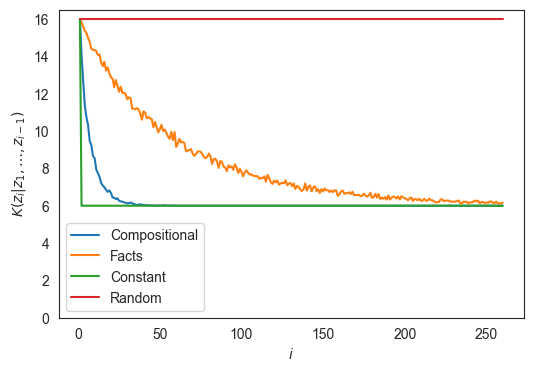

In [21]:
z_dim = 16
num_facts = 64
sentence_length = 2
vocab_size = 8
const_noise_dims = 6
assert num_facts == vocab_size**sentence_length == 2**const_noise_dims

preq_curves = preq_curve_comparison(
    datas={
        "Random": RandomData(z_dim=z_dim),
        "Constant": ConstantData(z_dim=z_dim, noise_dims=const_noise_dims),
        "Facts": FactData(z_dim=z_dim, num_facts=num_facts),
        "Compositional": CompositionalData(
            z_dim=z_dim, sentence_length=sentence_length, vocab_size=vocab_size
        ),
    },
    num_samples=260,
    num_repeats=1000,
)
preq_curves = preq_curves.groupby(["name", "i"])["k_z_next"].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=preq_curves,
    x="i",
    y="k_z_next",
    hue="name",
    hue_order=["Compositional", "Facts", "Constant", "Random"],
    ax=ax,
)
ax.set(xlabel="$i$", ylabel="$K(z_i | z_1, \ldots, z_{i-1})$", ylim=(0, None))
ax.legend()
plt.show()

# Multi-scale structure

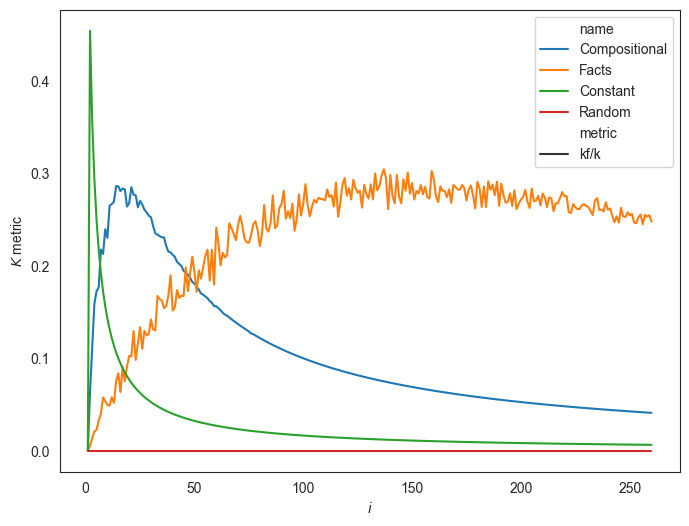

In [57]:
def k(preq_curve):
    return preq_curve.cumsum()


def k_uncompressed(preq_curve):
    k1 = preq_curve.iloc[0].item()
    preq_curve = preq_curve.copy()
    preq_curve[:] = k1
    return preq_curve.cumsum()


def k_entropy(preq_curve):
    return preq_curve * np.arange(1, len(preq_curve) + 1)


def k_shared(preq_curve):
    return k_uncompressed(preq_curve) - k(preq_curve)


def k_f(preq_curve):
    return k(preq_curve) - k_entropy(preq_curve)


preq_curves = preq_curves.sort_values(["name", "i"])
grouped = preq_curves.groupby("name")["k_z_next"]
preq_curves = preq_curves.assign(
    k=grouped.transform(k),
    k_shared=grouped.transform(k_shared),
    k_f=grouped.transform(k_f),
)
preq_curves["kf/k"] = preq_curves["k_f"] / preq_curves["k"]

pivoted = preq_curves.melt(
    id_vars=["name", "i"],
    value_vars=["k", "k_shared", "k_f", "kf/k"],
    var_name="metric",
    value_name="k_metric",
)

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(
    data=pivoted[pivoted["metric"] == "kf/k"],
    x="i",
    y="k_metric",
    hue="name",
    hue_order=["Compositional", "Facts", "Constant", "Random"],
    style="metric",
    ax=ax,
)
ax.set(xlabel="$i$", ylabel="$K$ metric")
ax.legend()
plt.show()

# Definition

$R(s) = \min_{K(f_s)} -\log_2(D_s | f_s) + K(f_s)$

# Properties

1. Yoshua thinks of a compositional model as one that compresses data with a high compression ratio. I agree, and we can turn this inside out to define compositional data: compositional data is data that can be compressed using a model (and we can consider the model the optimal Occam's razor one that achieves the best compression). Information $K(D)$ that keeps increasing but nevertheless stays modelable with similarly high compression ratio $R$. The thing is though that we have to define scales at which the data should be compressible, sine models might be tuned to one particular scale.
2. The data is structured to be maximally structured at one or more specified scales.
3. It captures the intuition that compositionality is about reuse of information and patterns  (high $R(s)$ ratio) at a particular scale.
4. Behaviour is nicely captured for both (a) data that is unstructured/random/noise and (b) data that is too structured/simple/repetitive.
   - If the data becomes too unstructured past a particular scale (e.g., datapoints are iid), then the model stays the same size while the data size keeps growing, making $R(s) \rightarrow 0$ as $s \rightarrow \infty$.
   - If the data becomes too structured past a particular scale (e.g., datapoints are all the same), then the model grows in complexity to capture the structure and eventually leaves no remaining uncertainty, making $R(s) \rightarrow 1$ as $s \rightarrow \infty$.
5. It captures the intuition that there is a tradeoff between data complexity/expressivity/discriminability and structure/model simplicity at a particular scale.
   - If there's too much reuse/structure past a particular scale (i.e., $R(s) \approx 1$), then nothing around that scale can be expressed/differentiated. It's like trying to discriminate between two images of dogs (described with a certain number of pixel bits) when the shared model $K(f_s)$ describes dog-image-scale data using hard-coded templates (which themselves might be included in the model because those templates keep getting reused at large scales, like at the scale of scenes).
   - Conversely, if there's not enough reuse/structure at a particular scale (i.e., $R(s) \approx 0$), then nothing at that scale can be efficiently compressed and the data is just random/noise. The entropy of the data at that scale when encoded using the model is just too high. It's like trying to talk about two images of dogs (described with a certain number of pixel bits) when the shared model $K(f_s)$ describes dog-image-scale data using very low-level descriptors about fine-grained texture (which themselves might be included in the model because they keep getting reused at smaller scales, like the scale of object parts).
6. This addresses the thought puzzle in which the "compositional" data above (the version of it where tokens can be reused within a sentence and have the same embeddings) is structurally identical to the "facts" version, only at different scales. What I mean here is that invidual datapoints now have embeddings, and sequences of those datapoints produce the reuse of parts.
7. There is a scale-free equivariance property to this picture, in which if we were to do something like replace every instance of bit $1$ with bits $01$ and every instance of bit $0$ with bits $10$, then the $R(s)$ curve would still look the same but stretched out by a factor of $2$ along the $x$-axis.
8. It clarifies my challenge to Yoshua who said all that matters is compression ratio of some observed data. I said that talking about representations could provide alternative perspectives and value, and one example that I cited was that you might not want to model/compress all of the low-level detail in the image. In my novel view of compositionality, this is easily explainable and achievable: we want to explain the data an abstract level using a representation that disregards and does not try to preserve fine-grained bits within invidiual datapoints (even if they might be compressible). We could specify this as an inductive bias by saying that we want to fit the simplest possible model that explains/reconstructs the data *at a particular scale*, without specifying the extra bits of entropy that we would need to reconstruct the data below that scale. Of course, we can pick these scales based on the compositionality profile of the data that we are trying to explain.

## Relation to combinations of parts and my prior definition

My prior definition said that data had to be described by a simple model of parts. Here, the "parts" are simply the entropy of data at a particular scale given the model. So literally, the data at some scale $d$ is modelable as a simple function of parts (you specify the entropy code, and I use a simple model to decode it, where the decoding scheme is some neglible part of the program like algorithmic coding).

So translating to something like the past language I used, the formula is something like: $R(s ; D) = \frac{K(D_s)}{K(f_s)} = \frac{K(f_s) + K(D_s | f_s)}{K(f)}$. So the part of admitting simple models is still here. The differences are:
- We don't want it to be close to $1$ or $0$ at any scale, but something in between. If it is $1$ then there are no parts at that scale (just one part that keeps repeating and requires no code to specify) and we have no expressivity. If it is $0$ then there are too many parts needed to describe things at the particular scale and we have no compression.
- We need it to be at some middling range at one or more scales, and it matters which scales. For instance, "noise" data is compositional, but only at the very small scale. At the larger scale, if the data is just noise then the model becomes far too simple compared to the data complexity that is growing linearly with entropy. Similarly, "constant" data is compositional, but only trivially at its own scale.
- For "compositionality at the dataset scale", what people typically mean is being able to compress a large number of datapoints $K(D_s)$ (s is the size of the dataset) using parts to discriminate them that are short codes in comparison to the model size: $K(D_s|f_s) \approx K(f_s) \implies 0 < \frac{K(D_s)}{f_s} < 1$.

This solves some of the headaches and hacks with the old definition, such as "is random noise compositional"? The answer is yes, but only at a very small scale. The model is simple (a noise model) and the entropy codes are small (noise is local so we're defining independent statistics if bits-sized objects). At larger scales, if the data is just noise, then $R(s)$ quickly drops off as $s$ increases. Specifically, here are some of the problems that the old definition had that the new one doesn't:
- Ill-defined. There was no single solution, and different solutions gave arbitrarily different answers about compositionality.
- More arbitrary structure (e.g. assuming some form of the generative model). The new one only has models and entropy.
- More unnecessary constraints (e.g. f(w) parametrizing a normal distribution, which is necessary otherwise p(z|f(w)) could just be the actually distribution over z and even the new version of the old formula still has unidentifiable issues where complexity can be arbitrarily traded off between pw and f). The new formulation has no constraints other than appealing to Occam’s razor (and even then we can define it for arbitrary learners and just call the Occam one a special case).
- Has notions of datapoints. The new one just considers a string of arbitrary length and can define compositionality across arbitrary scales. It accounts for within-datapoint compositional structure and hierarchical compositional structure, for instance.
- Assumes continuous Z (and has to arbitrarily discretize the normal distribution). The new one just considers a string.
- No upper bound. The new one is bounded between 0-1, as it is the opposite fraction in a way where we put model complexity in the numerator.
- Says that random noise is the most compositional thing we can have (and can even tend to infinity as the dataset Z grows)! The new one says that the story is more complicated and that middling values are where compositionality lives, where neither unstructured noise nor overly structured simple data is compositional.

## Relation to Sophistication

1. I need to think about whether $R(s)$ is a better quantity to track than $\texttt{soph}(D_s) / len(D_s)$. I think it is, but I need to think more about it.
2. The discussion of $R(s)$ being interesting between $(0, 1)$, and not at $1$, is relevant to something said in the last discussion point of the "Meaningful information" paper (I highlighted it in blue on the last page). Specifically, that part of the paper formalizes the intuition that an Occam's razor model which is too simple ($K(f_s) \approx 0$) necessarily means that the data is random and uncompressible, and that a model which is too complex ($K(f_s) \approx K(D_s)$) means that there is no more notion of "parts" or codes that identify the data under the model.

## Inifinite expressivity, hierarchical structure, open-endedness, and compositionality

What if we want to be able to discriminate ($R(s)$ not too high) using few bits ($R(s)$ not too low) a lot of information at many different scales and levels of abstraction? This would be a case where we need to be *hierarchically* compositional. Basically, we maintain a mid-range $R(s)$ ratio at all scales, and we do this by constructing a model that grows in complexity as needed to compress data at all scales.

Think what would happen if we optimized a dataset to satisfy this property? It would hierarchically use existing structure (parts and semantics, factors) to define novel structures. This involves defining new concepts as simple functions of existing ones, as well as their distribution. This is the way in which complex coding libraries grow, for instance, so that they serve a good use at many scales (both low-level and high-level).

Note that this would also imply an ever-growing world model that generates ever more complex structured data. This is the essence of open-endedness: the ability to continually generate novel data that is nevertheless learnable/compressible.

## Compositionality at different scales

- **Noise / very low-level statistics**: At local scales, the noise might be structured in a way where it can be partly compressed with the right noise model. This is the case when the noise is not white, but has some structure that can be exploited.
- **Feature / intra-object**: Objects within a datapoint are often composed as simple functions of reusable parts. This means that we have compositionality at the scale of objects: we strike a balance between describing many different objects in a compressed way using short codes that are interpreted by a simple world model (entropy and complexity are balanced).
- **Intra-datatpoint**: 
- **Inter-datapoint**: Large numbers of datapoints often reuse parts and semantics of an underlying factorized world model. This means that the structure of the data is tuned such that many different datapoints can be compressed using relatively short but discriminative codes. If the model was simpler, then the data would have to be simpler at this scale to be compressible (i.e., large numbers of datapoints look too similar to each other, with codes that are too similar and have low entropy). If the model was more complex, then the data would have to have much less structure and have more noise at this scale in order to be less compressible (higher entropy).
- **Large-scale dataset**: The data is structured, but only when you look across an extremely large number of datapoints. An example is where the datapoints themselves are "facts" that reappear in the data very sparsely. These independent facts are expensive to encode in a world model, and the data must therefore be diverse/less structured and have high entropy over these facts. They let us efficiently describe long sequences of repeating facts like stories, histories, and episodic memories as compositions of reocurring fact-like structures.
- **Curriculum-level**: The data is structured at increasingly large scales throughout a non-stationary dataset. The larger the scale, the more complex the concept library $K(f_s)$ (it could be increasing hierarchically, for instance) and the more complex the data.

*Note*: we might want to think about how to measure $R(s)$ for stationary vs. non-stationary data. For stationary data (or data that is stationary at least at some scale), we can just average over all (circular) contiguous windows. For data that is additionally iid, we can also average over all permutations of the datapoints. For data that is non-stationary, we should perhaps always start the window at the beginning of the data and then only increase the scale from there (giving us one window per scale).

# Experiment ideas

With this theory in hand, we can learn to generate data with pre-specified compositional profiles *de novo*, without any data to learn from. All we need to do is:
- Specify the intended compositionality profile $R(s)$ at different scales.
- Be able to efficiently measure $K(D_s)$ and $K(f_s)$ at many scales for the data we generate.
- Optimize the parameters of some generative model with respect to the mismatch between the intended $R(s)$ and the actual $\hat{R}(s)$ of the generated data.

All these can be achieved with... you guessed it... in-context learning! Since large pre-trained language models are pretty good universal compressors, we can use them to measure $\hat{R}(s)$ in cases where the data can be efficiently represented as a byte-sequence. We can also fine-tune this same pre-trained language model as the generative policy, or we can use some other model (e.g., a diffusion model trained with iDEM). The policy generating the data can either be trained using RL (in which case it would be generating a single fixed dataset), or it can (preferably) be a GFlowNet or iDEM model that generates a variety of different datasets with the same compositionality profiles.

## Experiment 1: An image / art piece

We can generate the images using an iDEM model and evaluate the reward using a pre-trained language model. Language models have been found to be good general compressors for image data when fed as a byte sequence, so this should work.

## Experiment 2: Gaussian process

A Gaussian process is defined in terms of a kernel that specifies the scale of the structure. From this, can we manually specify the indended compositionality profile $R(s)$ directly in the kernel and visually inspect it? The increasing complexity of the true model as a function of scale comes from specifying additional parts of the kernel at larger scales, and entropy at a scale comes from the summed entropy of the function distribution (variance of the Gaussian process) at that scale.